In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

In [3]:
seed = 42
splits = 5
repeats = 4
rskf = RepeatedStratifiedKFold(n_splits = splits, random_state = seed, n_repeats = repeats)
np.random.seed(seed)

In [4]:
train = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')
prediction = pd.read_csv("sample_submission.csv")

df = train.copy()
original = pd.read_csv("ObesityDataSet.csv")

In [23]:
df = pd.concat([train, original])
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [5]:
%run Pre_Processing.ipynb

In [6]:
X = df.drop(["NObeyesdad"], axis=1)
y = df.NObeyesdad

In [7]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation


In [8]:
target_mapping = {
    "Insufficient_Weight" : 0,
    "Normal_Weight" : 1,
    "Overweight_Level_I" : 2,
    "Overweight_Level_II" : 3,
    "Obesity_Type_I" : 4,
    "Obesity_Type_II" : 5,
    "Obesity_Type_III" : 6
}

y_mapped = y.map(target_mapping)
y_reverse_map = {v : k for k, v in target_mapping.items()}

In [9]:
ensemble = VotingClassifier(
    [
        ("LightGBM", LGBMClassifier(random_state=seed, verbose=-1)),
        ("XGBoost", XGBClassifier(random_state=seed))
    ],
    voting="soft",
    weights=None,
)

xgbcatlgbm = VotingClassifier(
    [
        ("LightGBM", LGBMClassifier(random_state=seed, verbose=-1)),
        ("XGBoost", XGBClassifier(random_state=seed)),
        ("Catboost", CatBoostClassifier(random_state=seed, verbose=0))
    ],
    voting="soft",
    weights=None,
)

In [22]:
models = [
    ('lda', LinearDiscriminantAnalysis()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('cat', CatBoostClassifier(random_state=seed, verbose=0)),
    ('xgb', XGBClassifier(random_state = seed, verbose=0)),
    ('lgb', LGBMClassifier(random_state = seed, verbose=-1)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart', verbose=-1)),
    ('ensemble', ensemble),
    ('xgbcatlgbm', xgbcatlgbm)
]
models_scores = []

cv = StratifiedKFold(n_splits=5, shuffle=True ,random_state=42)

for (label, model) in models:
    model_name = label
    pipeline = make_pipeline(preprocessor, model)
    y_pred = cross_val_predict(pipeline, X, y_mapped, cv=cv)
    accuracy = accuracy_score(y_mapped, y_pred)
    models_scores.append((model_name, accuracy))
    print(f"Accuracy Score for {model_name}: {accuracy}\n")

Accuracy Score for lda: 0.8276327199152134

Accuracy Score for rf: 0.9002794103478177

Accuracy Score for et: 0.883418441082956

Accuracy Score for cat: 0.9054822237209751

Accuracy Score for xgb: 0.9048077849503806

Accuracy Score for lgb: 0.9032180364196936

Accuracy Score for dart: 0.9016282878890066

Accuracy Score for ensemble: 0.9046632623566817

Accuracy Score for xgbcatlgbm: 0.9064457076789671



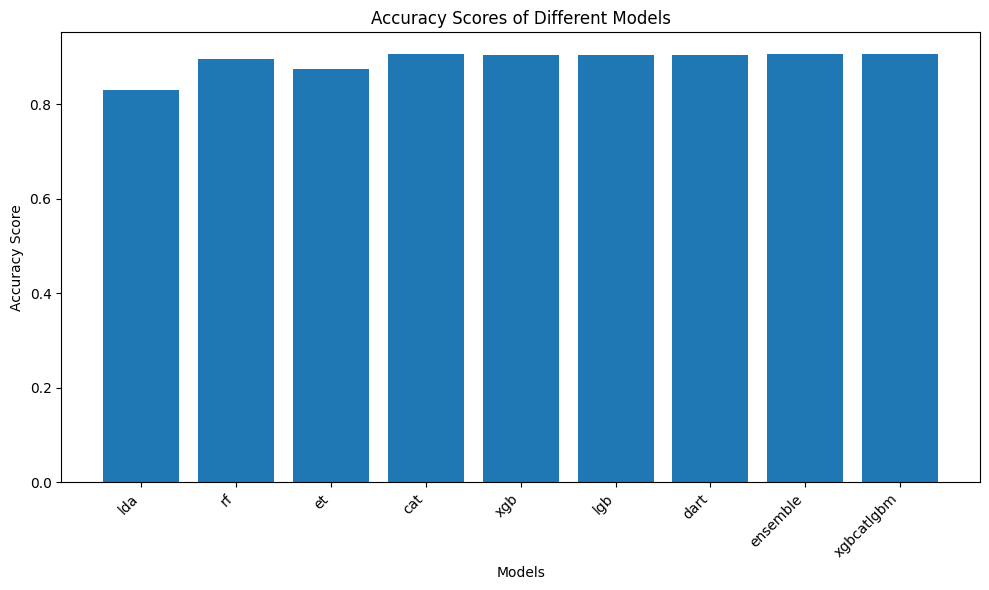

In [14]:
model_names, accuracies = zip(*models_scores)

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
def accuracy_eval(y_true, y_pred):
    """
    Custom evaluation function to compute accuracy.
    """
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_labels)
    return 'accuracy', accuracy, True

In [23]:
import optuna
from lightgbm import early_stopping

def objective(trial, data=preprocessed_train_df, target=y_mapped):
    
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2,random_state=42)
    
    param_grid = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : trial.suggest_int('n_estimators', 5, 1000),
        'random_state' : seed,
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
    }
    
    X_train.reset_index(drop=True, inplace=True)    
    y_train.reset_index(drop=True, inplace=True)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[test_idx]

        model = LGBMClassifier(**param_grid, verbose=-1)
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=accuracy_eval,   
            callbacks=[early_stopping(100)]
        )
        preds = model.predict_proba(X_val)
        y_pred_labels = np.argmax(preds, axis=1)
        cv_scores[idx] = accuracy_score(y_val, y_pred_labels)
    
    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=3600)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [31]:
from xgboost.callback import EarlyStopping

def objective(trial,data=preprocessed_train_df,target=y_mapped):
    
    early_stopping = EarlyStopping(rounds=100, maximize=True)
    
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2,random_state=42)
    
    param = {
        'random_state': 42,
        'n_estimators' : trial.suggest_int('n_estimators', 5, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
         'max_depth' : trial.suggest_int('max_depth', 2, 20),
    }
    
    X_train.reset_index(drop=True, inplace=True)    
    y_train.reset_index(drop=True, inplace=True)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[test_idx]

        model = XGBClassifier(**param, verbose=0)
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=accuracy_eval,   
            callbacks=[early_stopping]
        )
        preds = model.predict_proba(X_val)
        y_pred_labels = np.argmax(preds, axis=1)
        cv_scores[idx] = accuracy_score(y_val, y_pred_labels)
    
    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=3600)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [23]:
def objective(trial,data=preprocessed_train_df,target=y_mapped):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'iterations' : trial.suggest_int("iterations", 100, 1000),
        'learning_rate' : trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth' : trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg' : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type' : trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength' : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature' : trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type' : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait' : trial.suggest_int("od_wait", 10, 50),
        'verbose' : False
    }
    model = CatBoostClassifier(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)])
    
    preds = model.predict(test_x)
    
    accuracy = accuracy_score(test_y, preds)
    
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [10]:
lgbm_params = {
    'random_state': seed,
    'learning_rate': 0.05437546306468656, 
    'max_depth': 8, 
    'subsample': 0.7930715367724485, 
    'min_child_weight': 0.20548379310204978, 
    'reg_lambda': 11.946128155079071, 
    'reg_alpha': 0.9312728149550467, 
    'n_estimators': 334, 
    'num_leaves': 1000,
    'verbose': -1
}

dart_params = {
    'random_state' : seed,
    'n_estimators': 5000, 
    'reg_alpha': 2.156916332573565, 
    'reg_lambda': 0.0020442251900243155, 
    'colsample_bytree': 0.4, 
    'subsample': 0.4, 
    'learning_rate': 0.008, 
    'max_depth': 100, 
    'num_leaves': 92, 
    'min_child_samples': 86, 
    'min_data_per_groups': 61,
    'verbose': -1
}

xgb_params = {
    'random_state' : seed,
    'n_estimators': 20000, 
    'reg_alpha': 1.8139033219985152, 
    'reg_lambda': 1.68320446559976, 
    'colsample_bytree': 0.3, 
    'subsample': 0.5, 
    'learning_rate': 0.008, 
    'max_depth': 10
}

cat_params = {
    'iterations': 467, 
    'learning_rate': 0.07306038997735301, 
    'depth': 5, 
    'l2_leaf_reg': 0.20454589133303308, 
    'bootstrap_type': 'Bayesian', 
    'random_strength': 5.592253851702421e-06,
    'bagging_temperature': 0.362583079852707, 
    'od_type': 'Iter', 
    'od_wait': 40
}

model = LGBMClassifier(**lgbm_params)

# model = VotingClassifier(
#     [
#         ("LightGBM", LGBMClassifier(**lgbm_params)),
#         ("XGBoost", XGBClassifier(**xgb_params)),
#         ("CatBoost", CatBoostClassifier(**cat_params))
#     ],
#     voting="soft",
#     weights=None,
# )

In [11]:
X = calculate_bmi(X)

In [12]:
X = dietary_ratio(X)
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,bmi,dietary_ratio
id,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,28.259565,0.000000
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,23.422091,0.200000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,17.126706,0.260695
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,44.855798,0.314044
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,25.599151,0.498055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,36.587084,0.258262
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,17.099278,0.400000
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,31.889841,0.231608


In [13]:
preprocessed_train = preprocessor.fit_transform(X)
preprocessed_train_df = pd.DataFrame(preprocessed_train, columns=preprocessor.get_feature_names_out())
preprocessed_train_df

,pipeline__Gender_Female,pipeline__Gender_Male,pipeline__family_history_with_overweight_no,pipeline__family_history_with_overweight_yes,pipeline__FAVC_no,pipeline__FAVC_yes,pipeline__SMOKE_no,pipeline__SMOKE_yes,pipeline__SCC_no,pipeline__SCC_yes,...,powertransformer__Age,powertransformer__Height,powertransformer__Weight,powertransformer__FCVC,powertransformer__NCP,powertransformer__CH2O,powertransformer__FAF,powertransformer__TUE,remainder__bmi,remainder__dietary_ratio
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.628776,0.482565,0.398171,0.413482,0.438485,0.870095,0.000000,0.670343,0.365327,0.000000
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.344972,0.213996,0.180822,0.413482,0.445403,0.470459,0.472685,0.680461,0.250503,0.133333
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.344972,0.504374,0.114964,0.355029,0.041790,0.425690,0.423048,0.914376,0.101073,0.173797
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.501364,0.502986,0.773682,1.000000,0.445403,0.309966,0.626551,0.578819,0.759261,0.209363
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.787619,0.885845,0.496180,0.793147,0.133126,0.460351,0.765893,0.650624,0.302178,0.332036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.649035,0.608969,0.651264,0.946386,0.445403,0.547359,0.584130,0.194571,0.562992,0.172175
20754,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.344972,0.501598,0.113328,1.000000,1.000000,0.000000,0.774123,0.680461,0.100422,0.266667
20755,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.461943,0.708764,0.587125,0.631654,0.445403,0.470459,0.527766,0.759668,0.451497,0.154405
20756,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.820189,0.482569,0.413443,0.787948,0.133126,0.543799,0.000000,0.669197,0.380521,0.000000


In [14]:
test = calculate_bmi(test)
test = dietary_ratio(test)
test

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,bmi,dietary_ratio
id,,,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation,35.315411,0.146834
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation,25.781250,0.250000
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation,41.324115,0.000000
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation,42.976937,0.016455
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation,39.584143,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation,26.333478,0.201769
34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,24.524346,0.000000
34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation,17.652091,0.456237


In [15]:
preprocessed_test = preprocessor.transform(test)
preprocessed_test_df = pd.DataFrame(preprocessed_test, columns=preprocessor.get_feature_names_out())
preprocessed_test_df

,pipeline__Gender_Female,pipeline__Gender_Male,pipeline__family_history_with_overweight_no,pipeline__family_history_with_overweight_yes,pipeline__FAVC_no,pipeline__FAVC_yes,pipeline__SMOKE_no,pipeline__SMOKE_yes,pipeline__SCC_no,pipeline__SCC_yes,...,powertransformer__Age,powertransformer__Height,powertransformer__Weight,powertransformer__FCVC,powertransformer__NCP,powertransformer__CH2O,powertransformer__FAF,powertransformer__TUE,remainder__bmi,remainder__dietary_ratio
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.694795,0.762719,0.698249,0.958972,0.445403,0.903923,0.418976,0.000000,0.532807,0.097889
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.503438,0.291153,0.263405,0.413482,0.000000,1.000000,0.472685,0.000000,0.306501,0.166667
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.672387,0.374397,0.632177,1.000000,0.445403,0.793584,0.000000,0.240171,0.675432,0.000000
3,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.502529,0.200704,0.572629,0.413482,0.436268,0.882525,0.058899,0.000000,0.714664,0.010970
4,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.672387,0.343801,0.581485,1.000000,0.445403,0.810587,0.000000,0.558876,0.634131,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.593105,0.523235,0.367760,0.877218,0.445403,0.000000,0.400240,0.578032,0.319609,0.134513
13836,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.740529,0.271896,0.227232,1.000000,0.445403,0.470459,0.000000,0.000000,0.276666,0.000000
13837,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.579544,0.263314,0.056639,1.000000,0.203026,0.470459,0.761200,0.680461,0.113544,0.304158
13838,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.503438,0.329604,0.142641,0.413482,0.445403,0.470459,1.000000,1.000000,0.173906,0.400000


In [18]:
model.fit(preprocessed_train_df, y_mapped)

LGBMClassifier(learning_rate=0.05437546306468656, max_depth=8,
               min_child_weight=0.20548379310204978, n_estimators=334,
               num_leaves=1000, random_state=42, reg_alpha=0.9312728149550467,
               reg_lambda=11.946128155079071, subsample=0.7930715367724485,
               verbose=-1)

In [19]:
preds = model.predict(preprocessed_test_df)
preds

array([5, 2, 6, ..., 0, 1, 5], dtype=int64)

In [20]:
y_pred_inv = np.vectorize(y_reverse_map.get)(preds)
y_pred_inv

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype='<U19')

In [21]:
prediction["NObeyesdad"] = y_pred_inv
prediction.to_csv("./predictions/lgbm_bmi_ratio_allonehot_allyeo_minmax.csv", index=False)